In [ ]:
from google.colab import files 
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
# see if full_df is present in the data
!ls

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [ ]:
pip install -q tf-models-official

In [ ]:
pip install transformers

In [ ]:
import os
import shutil
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
# Get full dataset
df = pd.read_csv('full_df.csv', index_col = 0)
df['label'] = pd.Categorical(df['ideology'])
df['label'] = df.label.cat.codes
df.head(2)

,ideology,sentence,label
0,Liberal,"Apart from the legal rights , the fact that le...",1
1,Liberal,"Today , a sizable and growing number of indivi...",1


In [ ]:
print('Samples ', len(df))

 Samples  3402


In [ ]:
# Create tf datasets 
batch_size = 32
seed = 1

def tf_format_data(df, batch_size = batch_size, seed = seed): 
  features = df.sentence.values
  labels = df.label.values
  dataset = tf.data.Dataset.from_tensor_slices( (features, labels) )
  raw_df = dataset.shuffle(len(df), seed = seed).batch(batch_size)
  AUTOTUNE = tf.data.AUTOTUNE
  format_df = raw_df.cache().prefetch(buffer_size=AUTOTUNE) 
  return format_df

def stratified_10_fold_split(df, fold = 0, val = True, batch_size = batch_size, seed = seed): 
  df = df.sample(frac=1, random_state = seed) # shuffle data
  label_1 = df[df.label == df.label.unique()[0]].copy() # stratify data
  label_2 = df[df.label == df.label.unique()[1]].copy()
  #train1,test1 =  np.array_split(label_1, (fractions[:-1].cumsum() * len(label_1)).astype(int))
  #train2,test2 =  np.array_split(label_2, (fractions[:-1].cumsum() * len(label_2)).astype(int))
  # split train / test
  split = int(len(df) / (10 * 2)) 
  test1 = label_1.iloc[fold * split : fold * split + split]
  test2 = label_2.iloc[fold * split : fold * split + split]
  train1 = label_1[~label_1.index.isin(test1.index)]
  train2 = label_2[~label_2.index.isin(test2.index)]
  if val: 
    # then split train into train / val
    split = int(len(train1) / (9))
    val1 = train1.iloc[fold * split : fold * split + split]
    val2 = train2.iloc[fold * split : fold * split + split]
    train1 = train1[~train1.index.isin(val1.index)]
    train2 = train2[~train2.index.isin(val2.index)]
    # concatenate both labels 
    train, val, test = pd.concat([train1,train2]),pd.concat([val1,val2]),pd.concat([test1,test2])
    print('Train ', len(train)) 
    print('Val ', len(val)) 
    print('Test ', len(test)) 
    return tf_format_data(train, batch_size), tf_format_data(val, batch_size), tf_format_data(test, batch_size) 
  else: 
    # split only to train test, no val
    train, test = pd.concat([train1,train2]),pd.concat([test1,test2]) 
    print('Train ', len(train)) 
    print('Test ', len(test)) 
    return tf_format_data(train, batch_size), tf_format_data(test, batch_size)    

In [ ]:
# Split into stratified train, test, split
train, val, test = stratified_10_fold_split(df, fold = 0, val = True) 

Train  2722
Val  340
Test  340


In [ ]:
# Split into stratified train, test split
train, test = stratified_10_fold_split(df, fold = 0, val = False) 

Train  3062
Test  340


In [ ]:
# display examples of data after batching 
for text_batch, label_batch in train.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

Review: b'That means the village elders who dominate the leadership and control the content of these institutions are hammering away at your children , your family , and the values of our society .'
Label : 0
Review: b"If income is shrinking , cut expenses : It 's a debate inherently favorable to conservatism , which has long held the goal of shrinking the size of government ( a commitment that generally ignores defense spending to focus on domestic programs ) ."
Label : 0
Review: b'Producing ethanol is throwing good money after bad , which , of course , is why our government provides roughly three billion of our tax dollars in government subsidies to ethanol producers .'
Label : 0


In [ ]:
from official.nlp import optimization  # to create AdamW optmizer
#Load the BERT Classifier and Tokenizer alıng with Input modules
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [ ]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}



In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12'
bert_model_name = 'albert_en_base'
bert_model_name = 'talking-heads_base'
bert_model_name = 'experts_wiki_books'
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
bert_model_name = 'electra_base'

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_model_name

'electra_base'

In [ ]:
# load tf2 model to keras layer
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
# example input
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# look at bert outputs
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/google/electra_base/2
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.00230919  0.24666928  0.16008814 -0.6285395   0.54747945  0.40668243
 -0.00378289 -0.37462175 -0.14704047 -0.11781128  0.16752382 -0.02283238]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.0023092   0.25186318  0.16147716 ... -0.11695797 -0.1232006
   0.5140114 ]
 [ 0.28205982 -0.13266687 -0.28908524 ... -0.3730528   0.38848278
   0.32645902]
 [-0.20537065 -0.26151395  0.31546816 ... -0.19166869 -0.08777446
   0.62365305]
 ...
 [ 0.2692139  -0.27040043 -0.07593191 ...  0.54215837  0.20782079
  -0.3454342 ]
 [ 0.30528796 -0.27596924  0.01370729 ...  0.5524522   0.29699844
  -0.37749803]
 [ 0.33353394 -0.31717375  0.07107908 ...  0.55341345  0.32506827
  -0.3858174 ]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  #net = tf.keras.layers.Dense(1, activation='tanh', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.4673251]], shape=(1, 1), dtype=float32)


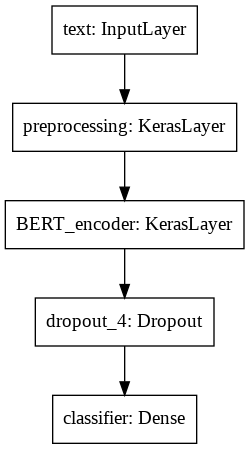

In [ ]:
# model structure
tf.keras.utils.plot_model(classifier_model)

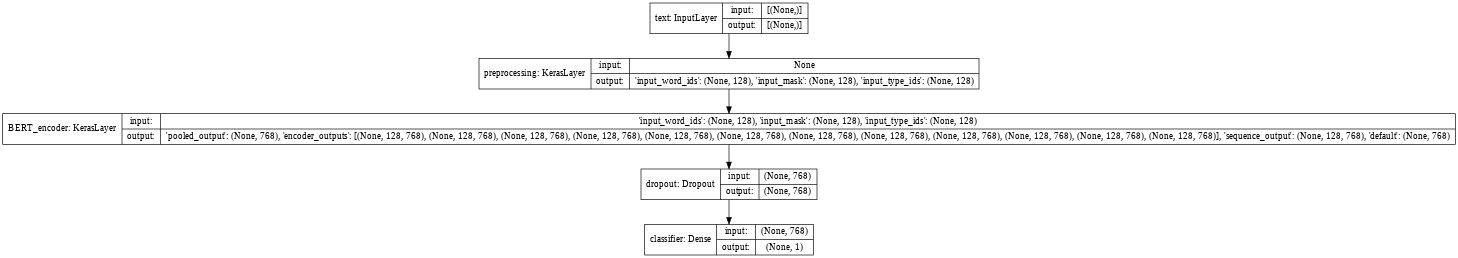

In [ ]:
tf.keras.utils.plot_model(classifier_model, show_shapes=True, dpi=48)

In [ ]:
# loss function 
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# optimizer
epochs = 4
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [ ]:
# load BERT model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
# Training with Val
print(f'Training model with {tfhub_handle_encoder}')

train, val, test = stratified_10_fold_split(df, fold = 0, val = True) 

history = classifier_model.fit(x=train,
                               validation_data=val,
                               epochs=epochs)

Training model with https://tfhub.dev/google/electra_base/2
Train  2722
Val  340
Test  340
Epoch 1/4
86/86 [==============================] - 91s 886ms/step - loss: 0.6967 - binary_accuracy: 0.5072 - val_loss: 0.6606 - val_binary_accuracy: 0.5382
Epoch 2/4
86/86 [==============================] - 79s 923ms/step - loss: 0.6325 - binary_accuracy: 0.5969 - val_loss: 0.6409 - val_binary_accuracy: 0.6382
Epoch 3/4
86/86 [==============================] - 79s 923ms/step - loss: 0.5312 - binary_accuracy: 0.7089 - val_loss: 0.6688 - val_binary_accuracy: 0.6559
Epoch 4/4
86/86 [==============================] - 79s 922ms/step - loss: 0.4054 - binary_accuracy: 0.7970 - val_loss: 0.7790 - val_binary_accuracy: 0.6441


In [ ]:
# Add validation data to training

print(f'Training model with {tfhub_handle_encoder}')

dummy_train, _ = stratified_10_fold_split(df, fold = 0, val = False) 

history = classifier_model.fit(x=dummy_train,
                               #validation_data=val,
                               epochs=epochs)

Training model with https://tfhub.dev/google/electra_base/2
Train  3062
Test  340
Epoch 1/4
96/96 [==============================] - 85s 890ms/step - loss: 0.3598 - binary_accuracy: 0.8488
Epoch 2/4
96/96 [==============================] - 85s 890ms/step - loss: 0.3597 - binary_accuracy: 0.8514
Epoch 3/4
96/96 [==============================] - 85s 888ms/step - loss: 0.3578 - binary_accuracy: 0.8445
Epoch 4/4
96/96 [==============================] - 85s 889ms/step - loss: 0.3535 - binary_accuracy: 0.8537


In [ ]:
# evaluate
loss, accuracy = classifier_model.evaluate(test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

11/11 [==============================] - 3s 312ms/step - loss: 0.8243 - binary_accuracy: 0.6176
Loss: 0.8243152499198914
Accuracy: 0.6176470518112183


In [ ]:
history = classifier_model.fit(x=dummy_train,
                               validation_data=test,
                               epochs=epochs)

Epoch 1/3
192/192 [==============================] - 92s 480ms/step - loss: 0.4178 - binary_accuracy: 0.8158 - val_loss: 0.7125 - val_binary_accuracy: 0.6500
Epoch 2/3
192/192 [==============================] - 92s 479ms/step - loss: 0.4185 - binary_accuracy: 0.8142 - val_loss: 0.7125 - val_binary_accuracy: 0.6500
Epoch 3/3
192/192 [==============================] - 92s 479ms/step - loss: 0.4067 - binary_accuracy: 0.8178 - val_loss: 0.7125 - val_binary_accuracy: 0.6500


In [ ]:
# average scores over all folds 
accuracies = []
for fold in range(10): 
  print('FOLD ', fold)
  dummy_train, dummy_test = stratified_10_fold_split(df, fold = fold, val = False) 
  history = classifier_model.fit(x=dummy_train,
                                #validation_data=val,
                                epochs=1)
  loss, accuracy = classifier_model.evaluate(dummy_test)
  accuracies.append(accuracy)
  print()


0


In [ ]:
# put all the above in one function to initialize for each bert mode

def bert_10_fold(epochs, init_lr, batch_size, bert_model_name = 'electra_base', do_fine_tuning = True, folds = 10): 
  print(bert_model_name)
  # get average accuracy on test (k-fold)
  accuracies = []
  for fold in range(folds): 
    print('FOLD ', fold)
    #load data - seed set upstream to 0 
    train, test = stratified_10_fold_split(df, fold = fold, val = False, batch_size = batch_size) 
    #load pre-trained model to keras
    tfhub_handle_encoder = map_name_to_handle[bert_model_name]
    tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

    # build classifier model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=do_fine_tuning, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
    classifier_model =  tf.keras.Model(text_input, net)

    #loss function & evaluation
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    # optimizer
    steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    
    # load BERT model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    
    # fit model and calculate accuracy on test    
    history = classifier_model.fit(x=train, validation_data=test, epochs=epochs)
    loss, accuracy = classifier_model.evaluate(test)
    accuracies.append(accuracy)

  return {bert_model_name: accuracies}

In [ ]:
# electra results
epochs = 3
init_lr = 2e-5
batch_size = 32

electra_results = bert_10_fold(epochs=epochs, init_lr=init_lr, batch_size = batch_size, bert_model_name = 'electra_base')

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 107s 925ms/step - loss: 0.7077 - binary_accuracy: 0.5192 - val_loss: 0.6587 - val_binary_accuracy: 0.5618
Epoch 2/3
96/96 [==============================] - 89s 922ms/step - loss: 0.6398 - binary_accuracy: 0.6092 - val_loss: 0.6396 - val_binary_accuracy: 0.6324
Epoch 3/3
11/11 [==============================] - 3s 310ms/step - loss: 0.6501 - binary_accuracy: 0.6412
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 104s 930ms/step - loss: 0.7178 - binary_accuracy: 0.5089 - val_loss: 0.6405 - val_binary_accuracy: 0.5971
Epoch 2/3
96/96 [==============================] - 89s 924ms/step - loss: 0.6392 - binary_accuracy: 0.5967 - val_loss: 0.6100 - val_binary_accuracy: 0.6735
Epoch 3/3
11/11 [==============================] - 3s 311ms/step - loss: 0.6122 - binary_accuracy: 0.6912
FOLD  2
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 104s 932ms/step - loss: 0.7044 - binary_accuracy: 0.5143 - val_loss: 0.6409 - val_binary_accuracy: 0.5824
Epoch 2/3
96/96 [==============================] - 89s 923ms/step - loss: 0.6420 - binary_accuracy: 0.6050 - val_loss: 0.6149 - val_binary_accuracy: 0.6588
Epoch 3/3
11/11 [==============================] - 3s 311ms/step - loss: 0.6208 - binary_accuracy: 0.6971
FOLD  3
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 104s 931ms/step - loss: 0.7018 - binary_accuracy: 0.5274 - val_loss: 0.6554 - val_binary_accuracy: 0.5500
Epoch 2/3
96/96 [==============================] - 89s 923ms/step - loss: 0.6303 - binary_accuracy: 0.6260 - val_loss: 0.6525 - val_binary_accuracy: 0.6147
Epoch 3/3
11/11 [==============================] - 3s 307ms/step - loss: 0.6634 - binary_accuracy: 0.6324
FOLD  4
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 106s 936ms/step - loss: 0.6952 - binary_accuracy: 0.5110 - val_loss: 0.6628 - val_binary_accuracy: 0.5588
Epoch 2/3
96/96 [==============================] - 89s 927ms/step - loss: 0.6285 - binary_accuracy: 0.6085 - val_loss: 0.6551 - val_binary_accuracy: 0.6088
Epoch 3/3
11/11 [==============================] - 3s 308ms/step - loss: 0.6666 - binary_accuracy: 0.6441
FOLD  5
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 107s 933ms/step - loss: 0.7057 - binary_accuracy: 0.5154 - val_loss: 0.6696 - val_binary_accuracy: 0.5382
Epoch 2/3
96/96 [==============================] - 89s 926ms/step - loss: 0.6308 - binary_accuracy: 0.6146 - val_loss: 0.6625 - val_binary_accuracy: 0.6118
Epoch 3/3
11/11 [==============================] - 3s 311ms/step - loss: 0.6672 - binary_accuracy: 0.6294
FOLD  6
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 107s 932ms/step - loss: 0.7024 - binary_accuracy: 0.5173 - val_loss: 0.6553 - val_binary_accuracy: 0.5382
Epoch 2/3
96/96 [==============================] - 89s 923ms/step - loss: 0.6410 - binary_accuracy: 0.5991 - val_loss: 0.6162 - val_binary_accuracy: 0.6529
Epoch 3/3
11/11 [==============================] - 3s 307ms/step - loss: 0.6097 - binary_accuracy: 0.6676
FOLD  7
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 104s 932ms/step - loss: 0.7188 - binary_accuracy: 0.4886 - val_loss: 0.6546 - val_binary_accuracy: 0.5647
Epoch 2/3
96/96 [==============================] - 89s 925ms/step - loss: 0.6333 - binary_accuracy: 0.6016 - val_loss: 0.6375 - val_binary_accuracy: 0.6206
Epoch 3/3
11/11 [==============================] - 3s 309ms/step - loss: 0.6607 - binary_accuracy: 0.6294
FOLD  8
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 108s 933ms/step - loss: 0.6955 - binary_accuracy: 0.5280 - val_loss: 0.6515 - val_binary_accuracy: 0.5500
Epoch 2/3
96/96 [==============================] - 89s 924ms/step - loss: 0.6364 - binary_accuracy: 0.6047 - val_loss: 0.6241 - val_binary_accuracy: 0.6647
Epoch 3/3
11/11 [==============================] - 3s 311ms/step - loss: 0.6234 - binary_accuracy: 0.6706
FOLD  9
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 107s 934ms/step - loss: 0.7154 - binary_accuracy: 0.5103 - val_loss: 0.6557 - val_binary_accuracy: 0.5647
Epoch 2/3
96/96 [==============================] - 89s 923ms/step - loss: 0.6206 - binary_accuracy: 0.6176 - val_loss: 0.6399 - val_binary_accuracy: 0.6500
Epoch 3/3
11/11 [==============================] - 3s 312ms/step - loss: 0.6499 - binary_accuracy: 0.6353


In [ ]:
electra_results

{'electra_base': [0.6411764621734619,
  0.6911764740943909,
  0.6970587968826294,
  0.6323529481887817,
  0.6441176533699036,
  0.6294117569923401,
  0.6676470637321472,
  0.6294117569923401,
  0.6705882549285889,
  0.6352941393852234]}

In [ ]:
np.mean(electra_results['electra_base'])

0.6538235306739807

In [ ]:
# evaluate - Electra, best model
loss, accuracy = classifier_model.evaluate(test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

22/22 [==============================] - 6s 290ms/step - loss: 0.6589 - binary_accuracy: 0.6754
Loss: 0.6589404344558716
Accuracy: 0.6754385828971863


In [ ]:
# keep collab open 
while True:pass

KeyboardInterrupt: ignored

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


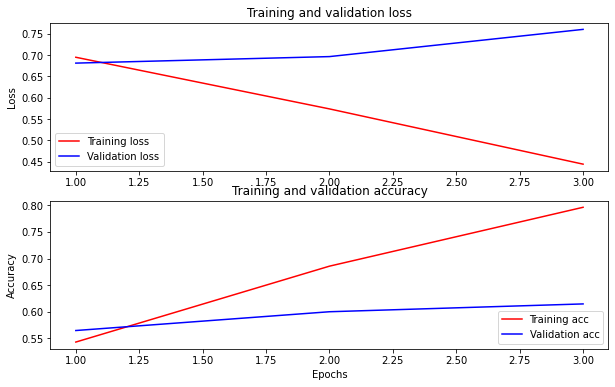

In [ ]:
# plot loss over time 
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# save model
dataset_name = 'baseline_electra_ibc'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
# reload saved model
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
# test on new input
